* `Import Libraries`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer 
from wordcloud import WordCloud
import spacy
import re
import os
import joblib
import string 

# LDA
import gensim
from gensim import corpora, models
from gensim.models import LdaModel, CoherenceModel
from gensim.utils import simple_preprocess

# NMF 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation 


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Abdallah
[nltk_data]     Samir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Abdallah
[nltk_data]     Samir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Abdallah
[nltk_data]     Samir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

* `Read The Dataset`

In [2]:
FILE_PATH = os.path.join(os.getcwd(),"bbc_news.csv") 
df = pd.read_csv(FILE_PATH) 
df.head()


,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


* `EDA`

In [3]:
df = df[['title', 'description']]

In [4]:
df['full_text'] = df['title'] + ' ' + df['description'] 
df.drop(['title','description'],axis=1,inplace=True)

In [5]:
df.head()

,full_text
0,Ukraine: Angry Zelensky vows to punish Russian...
1,War in Ukraine: Taking cover in a town under a...
2,Ukraine war 'catastrophic for global food' One...
3,Manchester Arena bombing: Saffie Roussos's par...
4,Ukraine conflict: Oil price soars to highest l...


In [6]:
df.shape

(42115, 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42115 entries, 0 to 42114
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  42115 non-null  object
dtypes: object(1)
memory usage: 329.2+ KB


In [8]:
df.describe()

,full_text
count,42115
unique,40111
top,Election poll tracker: How do the parties comp...
freq,34


* `Text Cleaning & Vizualization`

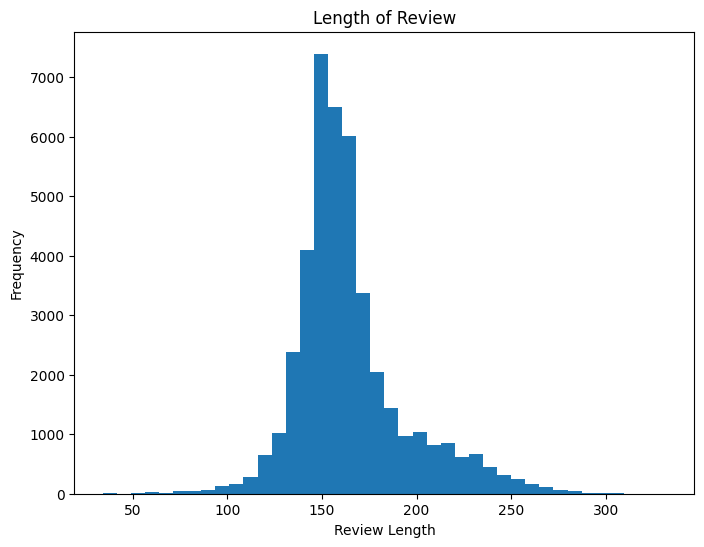

In [9]:
# Sequence Length
length_review = df['full_text'].str.len()
plt.figure(figsize=(8, 6))
plt.hist(length_review, bins=40)
plt.title('Length of Review')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Remove unwanted text patterns from the review
def remove_pattern(input_text,pattern):
    return re.sub(pattern,' ',input_text)

* `Remove Punctuation, Numbers, Special Chars`

In [11]:
# Remove special characters and digits and Convert to lowercase
df['full_text'] = df['full_text'].str.lower()
df.loc[:,'full_text'] = df['full_text'].apply(lambda x :remove_pattern(x,r'[^a-zA-Z\s]'))
df.loc[:,'full_text'] = df['full_text'].str.replace('\s+', ' ',regex=True)
df.head()

,full_text
0,ukraine angry zelensky vows to punish russian ...
1,war in ukraine taking cover in a town under at...
2,ukraine war catastrophic for global food one o...
3,manchester arena bombing saffie roussos s pare...
4,ukraine conflict oil price soars to highest le...


#### `Remove Repeated Characters`

In [12]:
# A Function to remove excessive repeated chars while preserving correct words
def remove_excessive_repeated_characters(input_string, max_repeats=2):
    # Define a regular expression pattern to match consecutive repeated characters
    pattern = f"(\\w)\\1{{{max_repeats},}}"
    # Replace the matched pattern with a single occurrence of the character
    cleaned_string = re.sub(pattern, r"\1", input_string)
    
    return cleaned_string

# Apply the above function
df.loc[:, 'full_text'] = df['full_text'].apply(remove_excessive_repeated_characters)
df.head()

,full_text
0,ukraine angry zelensky vows to punish russian ...
1,war in ukraine taking cover in a town under at...
2,ukraine war catastrophic for global food one o...
3,manchester arena bombing saffie roussos s pare...
4,ukraine conflict oil price soars to highest le...


* `Removing short words`

In [13]:
df.loc[:, 'full_text'] = df['full_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
df.head()

,full_text
0,ukraine angry zelensky vows punish russian atr...
1,ukraine taking cover town under attack jeremy ...
2,ukraine catastrophic global food world biggest...
3,manchester arena bombing saffie roussos parent...
4,ukraine conflict price soars highest level sin...


* `Remove Numbers from Words`

In [14]:
df.loc[:, 'full_text'] = df['full_text'].apply(lambda x: remove_pattern(x, '(?<=\w)\d+|\d+(?=\w)'))
df.head()

,full_text
0,ukraine angry zelensky vows punish russian atr...
1,ukraine taking cover town under attack jeremy ...
2,ukraine catastrophic global food world biggest...
3,manchester arena bombing saffie roussos parent...
4,ukraine conflict price soars highest level sin...


* `Remove Special Chars`

In [15]:
df.loc[:, 'full_text'] = df['full_text'].apply(lambda x: remove_pattern(x, r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/]'))
df.head()

,full_text
0,ukraine angry zelensky vows punish russian atr...
1,ukraine taking cover town under attack jeremy ...
2,ukraine catastrophic global food world biggest...
3,manchester arena bombing saffie roussos parent...
4,ukraine conflict price soars highest level sin...


* `Rmeove Redundant words`

In [16]:
# A Function to remove redundant words like (I've, You'll)
# Again, It is challenging

def remove_redundant_words_extra_spaces(text: str):
    # Remove contractions using regular expressions
    contraction_pattern = re.compile(r"'\w+|\w+'\w+|\w+'")
    text = contraction_pattern.sub('', text)

    # Define a set of stopwords
    stop_words = set(stopwords.words("english"))

    # Remove stopwords and extra spaces
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)

    # Remove extra spaces
    clean_text = ' '.join(clean_text.split())
    
    return clean_text


# Apply the above function
df.loc[:, 'full_text'] = df['full_text'].apply(remove_redundant_words_extra_spaces)
df.head()

,full_text
0,ukraine angry zelensky vows punish russian atr...
1,ukraine taking cover town attack jeremy bowen ...
2,ukraine catastrophic global food world biggest...
3,manchester arena bombing saffie roussos parent...
4,ukraine conflict price soars highest level sin...


* `Tokenization`

In [17]:
tokenize_full_text = df['full_text'].apply(lambda x : word_tokenize(x)) 
tokenize_full_text.head()

0    [ukraine, angry, zelensky, vows, punish, russi...
1    [ukraine, taking, cover, town, attack, jeremy,...
2    [ukraine, catastrophic, global, food, world, b...
3    [manchester, arena, bombing, saffie, roussos, ...
4    [ukraine, conflict, price, soars, highest, lev...
Name: full_text, dtype: object

* ` lemmatization`

In [18]:
lemmatizer = WordNetLemmatizer() 
tokenize_full_text = tokenize_full_text.apply(lambda x:[lemmatizer.lemmatize(i) for i in x]) 
tokenize_full_text

0        [ukraine, angry, zelensky, vow, punish, russia...
1        [ukraine, taking, cover, town, attack, jeremy,...
2        [ukraine, catastrophic, global, food, world, b...
3        [manchester, arena, bombing, saffie, roussos, ...
4        [ukraine, conflict, price, soar, highest, leve...
                               ...                        
42110    [highlight, wale, make, history, dublin, watch...
42111    [gang, jailed, cocaine, banana, box, tonne, cl...
42112    [scottish, budget, present, huge, challenge, f...
42113    [celebration, wale, make, history, qualifying,...
42114    [school, tell, muslim, girl, safe, three, chil...
Name: full_text, Length: 42115, dtype: object

In [19]:
df.loc[:,'full_text'] = tokenize_full_text.apply(lambda x : ' '.join(x)) 
df.head()

,full_text
0,ukraine angry zelensky vow punish russian atro...
1,ukraine taking cover town attack jeremy bowen ...
2,ukraine catastrophic global food world biggest...
3,manchester arena bombing saffie roussos parent...
4,ukraine conflict price soar highest level sinc...


In [20]:
texts = tokenize_full_text.tolist() 
processed_docs = df['full_text'].tolist()  
print("Text preprocessing completed!")
print(f"Number of documents: {len(texts)}")
print(f"Sample processed text: {texts[0][:10]}")

Text preprocessing completed!
Number of documents: 42115
Sample processed text: ['ukraine', 'angry', 'zelensky', 'vow', 'punish', 'russian', 'atrocity', 'ukrainian', 'president', 'say']


* `Corpus (Gensim)`

In [21]:
dictionary = corpora.Dictionary(texts)

print(f"Dictionary created with {len(dictionary)} unique tokens")


dictionary.filter_extremes(
    no_below=2,     
    no_above=0.8,   
    keep_n=1000     
)


Dictionary created with 30002 unique tokens


In [22]:
print(f"After filtering: {len(dictionary)} unique tokens")


corpus = [dictionary.doc2bow(text) for text in texts]
print(f"Corpus created with {len(corpus)} documents")

After filtering: 1000 unique tokens
Corpus created with 42115 documents


* ` (LDA) to extract dominant topics`

Testing 2 topics...
Topics: 2, Perplexity: 685.01
Testing 3 topics...
Topics: 3, Perplexity: 659.14
Testing 4 topics...
Topics: 4, Perplexity: 621.00
Testing 5 topics...
Topics: 5, Perplexity: 589.91
Testing 6 topics...
Topics: 6, Perplexity: 586.69
Testing 7 topics...
Topics: 7, Perplexity: 561.75
Testing 8 topics...
Topics: 8, Perplexity: 560.72


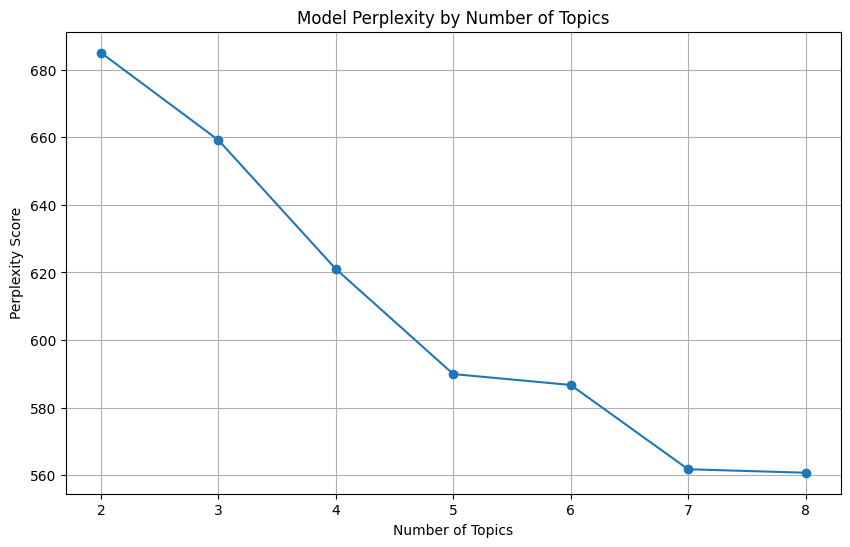

Optimal number of topics: 8

Training final LDA model with 8 topics...

Top 10 words for each topic:

Topic 1:
--------------------
police          (1904.125)
year            (1486.459)
child           (1264.125)
family          (1178.665)
say             (1156.728)
israel          (1115.910)
gaza            (1071.125)
death           (1064.259)
woman           (1058.252)
attack          (830.269)

Topic 2:
--------------------
world           (1075.390)
year            (836.962)
championship    (697.230)
win             (672.125)
paris           (649.125)
week            (632.562)
open            (597.315)
record          (564.575)
britain         (561.205)
seven           (534.822)

Topic 3:
--------------------
england         (3798.393)
world           (2921.860)
woman           (1146.003)
final           (977.707)
say             (917.853)
wale            (798.013)
euro            (739.125)
star            (672.926)
australia       (646.125)
test            (637.345)

Topic 4:
---

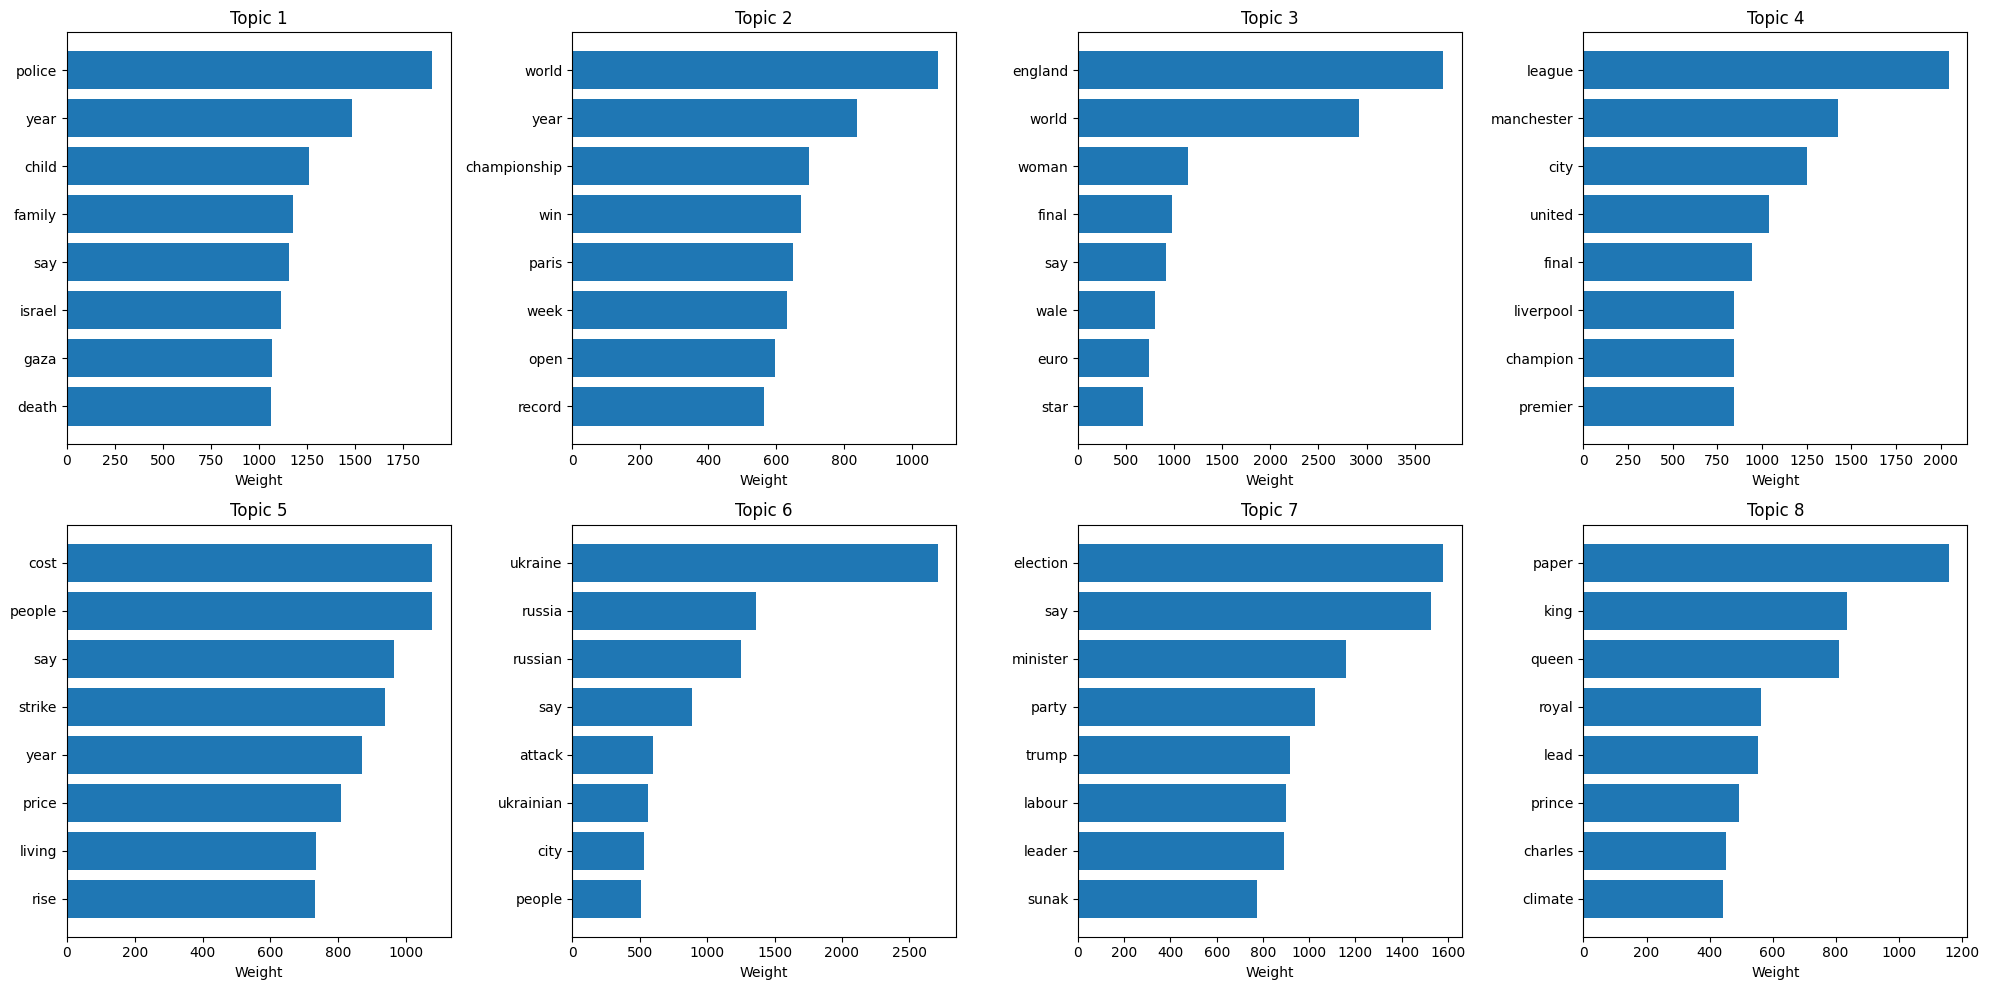

In [23]:
def find_optimal_topics_sklearn(texts, min_topics=2, max_topics=10):
    """Find optimal number of topics using sklearn LDA"""
    
    # Prepare the data
    vectorizer = CountVectorizer(
        max_features=1000,
        min_df=2,
        max_df=0.8,
        stop_words='english'
    )
    
    doc_term_matrix = vectorizer.fit_transform(texts)
    
    # Test different numbers of topics
    perplexity_scores = []
    topic_range = range(min_topics, max_topics + 1)
    
    for n_topics in topic_range:
        print(f"Testing {n_topics} topics...")
        
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=10  # Fast training
        )
        
        lda.fit(doc_term_matrix)
        perplexity = lda.perplexity(doc_term_matrix)
        perplexity_scores.append(perplexity)
        print(f"Topics: {n_topics}, Perplexity: {perplexity:.2f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(topic_range, perplexity_scores, marker='o')
    plt.xlabel('Number of Topics')
    plt.ylabel('Perplexity Score')
    plt.title('Model Perplexity by Number of Topics')
    plt.grid(True)
    plt.show()
    
    # Find optimal number of topics (lowest perplexity)
    optimal_idx = np.argmin(perplexity_scores)
    optimal_topics = list(topic_range)[optimal_idx]
    
    return optimal_topics, perplexity_scores, vectorizer, doc_term_matrix

Testing 2 topics...
Topics: 2, Perplexity: 685.01
Testing 3 topics...
Topics: 3, Perplexity: 659.14
Testing 4 topics...
Topics: 4, Perplexity: 621.00
Testing 5 topics...
Topics: 5, Perplexity: 589.91
Testing 6 topics...
Topics: 6, Perplexity: 586.69
Testing 7 topics...
Topics: 7, Perplexity: 561.75
Testing 8 topics...
Topics: 8, Perplexity: 560.72


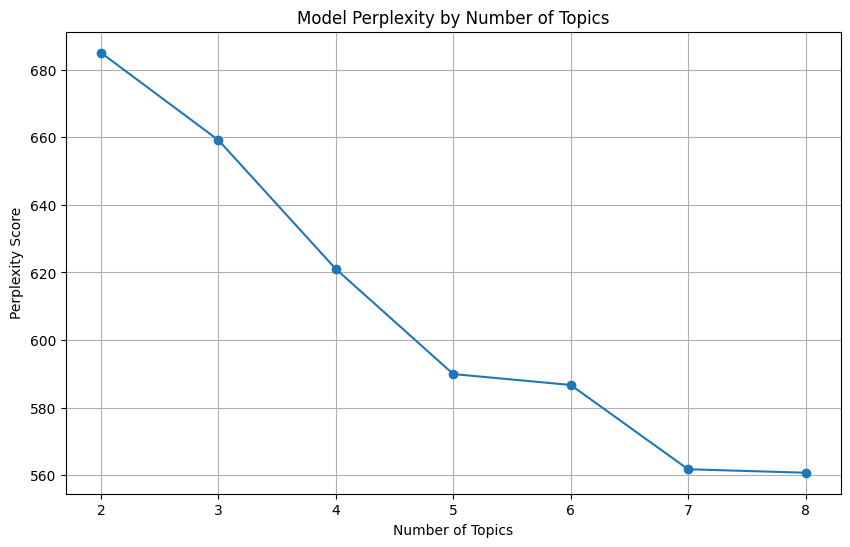

Optimal number of topics: 8

Training final LDA model with 8 topics...


In [24]:
# Run the optimization
optimal_n_topics, scores, vectorizer, doc_term_matrix = find_optimal_topics_sklearn(
    texts=[' '.join(text) for text in texts],  # Convert word lists to text strings
    min_topics=2,
    max_topics=8
)

print(f"Optimal number of topics: {optimal_n_topics}")

# Train the final model with optimal number of topics
print(f"\nTraining final LDA model with {optimal_n_topics} topics...")
final_lda = LatentDirichletAllocation(
    n_components=optimal_n_topics,
    random_state=42,
    max_iter=20  # More iterations for final model
)

In [25]:
final_lda.fit(doc_term_matrix)

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

* `Final Traning Model`

In [26]:
# Display topics and their top words
def display_topics(model, feature_names, n_top_words=10):
    """Display the top words for each topic"""
    print(f"\nTop {n_top_words} words for each topic:")
    print("=" * 60)
    
    for topic_idx, topic in enumerate(model.components_):
        # Get indices of top words
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_weights = [topic[i] for i in top_words_idx]
        
        print(f"\nTopic {topic_idx + 1}:")
        print("-" * 20)
        for word, weight in zip(top_words, top_weights):
            print(f"{word:15s} ({weight:.3f})")

In [27]:
# Display the topics
display_topics(final_lda, feature_names, n_top_words=10)

# Analyze document-topic distribution
doc_topic_dist = final_lda.transform(doc_term_matrix)

print(f"\nDocument-Topic Distribution Shape: {doc_topic_dist.shape}")
print(f"Each document has a probability distribution over {optimal_n_topics} topics")

# Show example: dominant topic for first few documents
print(f"\nDominant topics for first 10 documents:")
print("=" * 40)
for i in range(min(10, len(doc_topic_dist))):
    dominant_topic = np.argmax(doc_topic_dist[i])
    confidence = doc_topic_dist[i][dominant_topic]
    print(f"Document {i+1}: Topic {dominant_topic+1} (confidence: {confidence:.3f})")

# Topic distribution summary
print(f"\nTopic Distribution Summary:")
print("=" * 30)
topic_counts = np.argmax(doc_topic_dist, axis=1)
for topic_num in range(optimal_n_topics):
    count = np.sum(topic_counts == topic_num)
    percentage = (count / len(topic_counts)) * 100
    print(f"Topic {topic_num+1}: {count} documents ({percentage:.1f}%)")



Top 10 words for each topic:

Topic 1:
--------------------
police          (1904.125)
year            (1486.459)
child           (1264.125)
family          (1178.665)
say             (1156.728)
israel          (1115.910)
gaza            (1071.125)
death           (1064.259)
woman           (1058.252)
attack          (830.269)

Topic 2:
--------------------
world           (1075.390)
year            (836.962)
championship    (697.230)
win             (672.125)
paris           (649.125)
week            (632.562)
open            (597.315)
record          (564.575)
britain         (561.205)
seven           (534.822)

Topic 3:
--------------------
england         (3798.393)
world           (2921.860)
woman           (1146.003)
final           (977.707)
say             (917.853)
wale            (798.013)
euro            (739.125)
star            (672.926)
australia       (646.125)
test            (637.345)

Topic 4:
--------------------
league          (2045.125)
manchester      (1422.125)

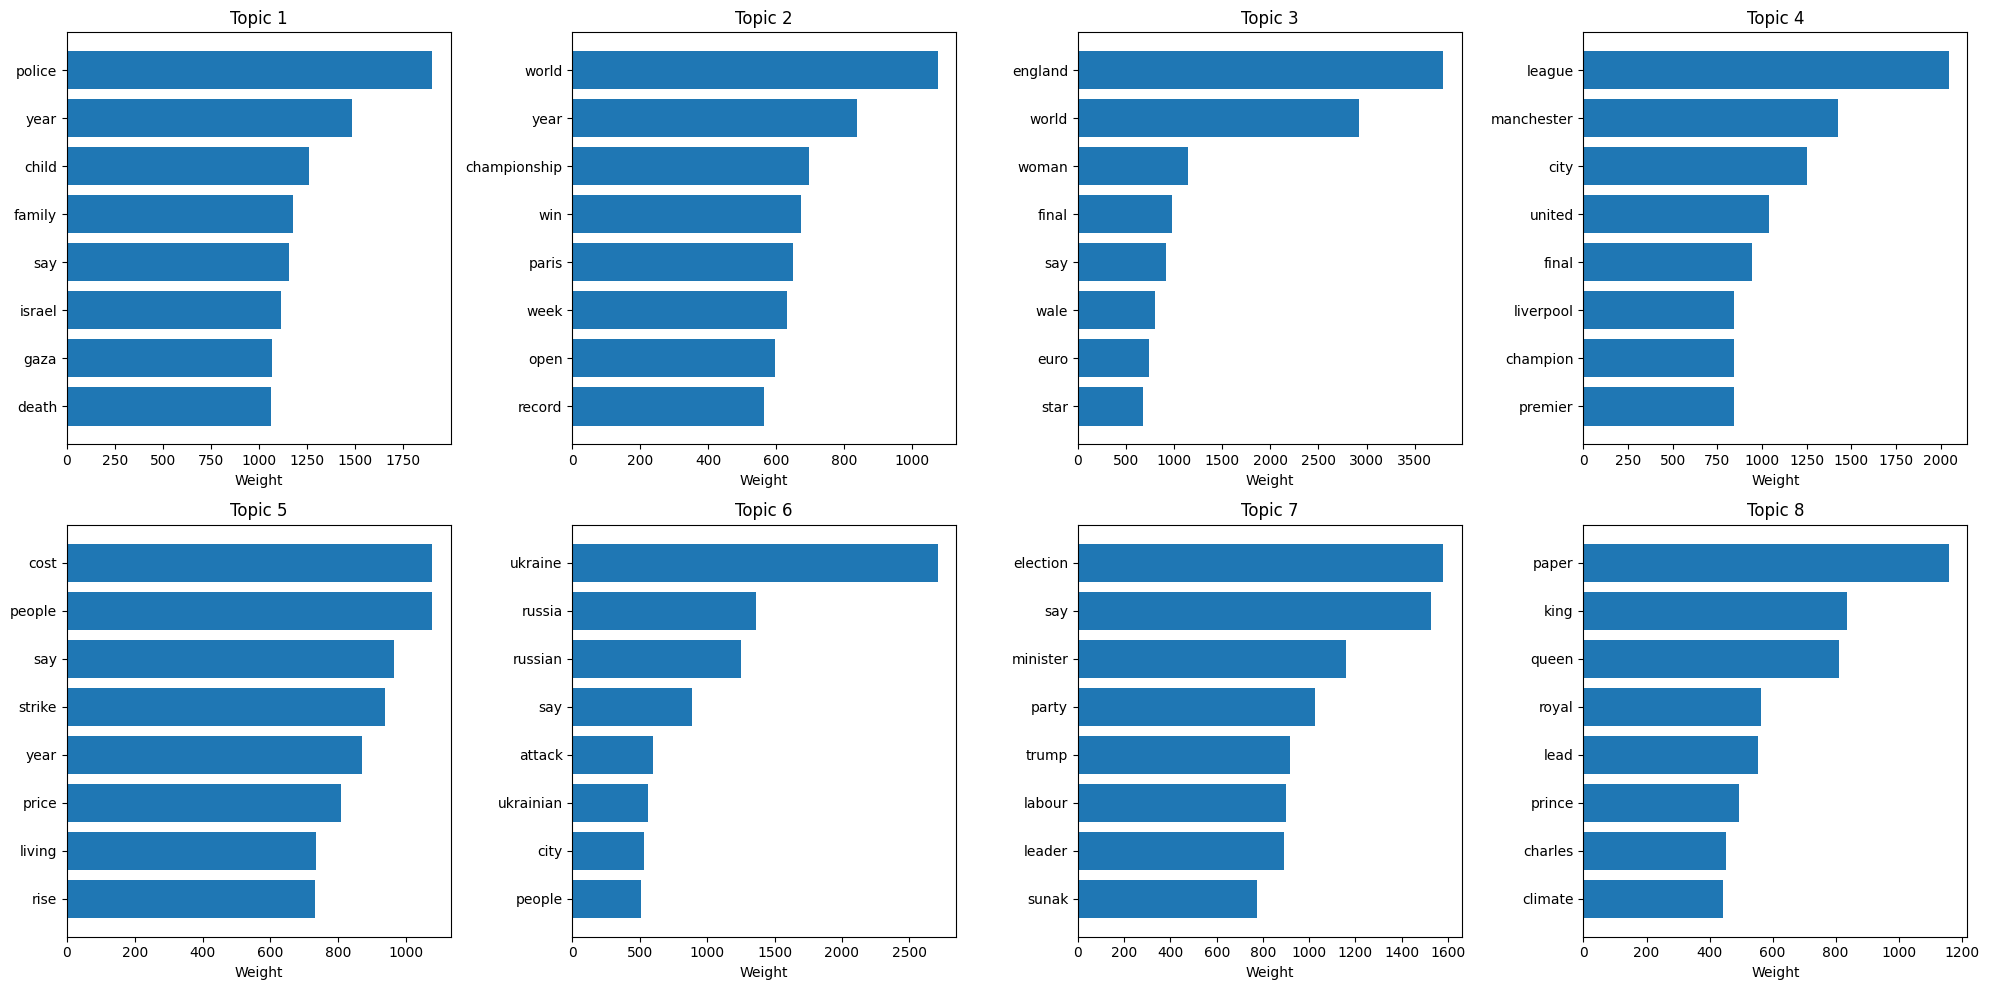

In [28]:
#Visualize topic-word distribution (optional - requires additional setup)
def plot_top_words(model, feature_names, n_top_words=8):
    """Plot top words for each topic"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx >= len(axes):
            break
            
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_weights = [topic[i] for i in top_words_idx]
        
        axes[topic_idx].barh(range(n_top_words), top_weights[::-1])
        axes[topic_idx].set_yticks(range(n_top_words))
        axes[topic_idx].set_yticklabels(top_words[::-1])
        axes[topic_idx].set_xlabel('Weight')
        axes[topic_idx].set_title(f'Topic {topic_idx + 1}')
    
    plt.tight_layout()
    plt.show()

# Plot the topics
plot_top_words(final_lda, feature_names, n_top_words=8)

In [31]:
def extract_topic_words(model, feature_names, n_top_words=10):
    """Extract top words for each topic"""
    topic_words = []
    
    for topic_idx, topic in enumerate(model.components_):
        # Get indices of top words
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topic_words.append(top_words)
    
    return topic_words

In [29]:
def create_topic_names(topic_words):
    """Create meaningful names for topics based on their top words"""
    topic_names = []
    
    for i, words in enumerate(topic_words):
        if len(words) > 0:
            # Join words and convert to lowercase for checking
            words_str = ' '.join(words).lower()
            
            # Check for different topic categories
            if any(word in words_str for word in ['government', 'political', 'minister', 'election', 'party', 'vote', 'parliament']):
                topic_names.append('Politics')
            elif any(word in words_str for word in ['business', 'company', 'market', 'economic', 'economy', 'financial', 'bank', 'money']):
                topic_names.append('Business')
            elif any(word in words_str for word in ['sport', 'team', 'game', 'player', 'match', 'football', 'cricket', 'tennis']):
                topic_names.append('Sports')
            elif any(word in words_str for word in ['technology', 'computer', 'digital', 'tech', 'internet', 'software', 'online']):
                topic_names.append('Technology')
            elif any(word in words_str for word in ['health', 'medical', 'hospital', 'patient', 'doctor', 'disease', 'treatment']):
                topic_names.append('Health')
            elif any(word in words_str for word in ['education', 'school', 'student', 'university', 'teacher', 'learning']):
                topic_names.append('Education')
            elif any(word in words_str for word in ['environment', 'climate', 'environmental', 'energy', 'green', 'carbon']):
                topic_names.append('Environment')
            elif any(word in words_str for word in ['entertainment', 'film', 'movie', 'music', 'celebrity', 'show']):
                topic_names.append('Entertainment')
            else:
                # Use the most representative word as topic name
                topic_names.append(f"Topic_{words[0].title()}")
        else:
            topic_names.append(f"Topic_{i+1}")
    
    return topic_names

In [33]:
# Extract topic words and create names
topic_words = extract_topic_words(final_lda, feature_names, n_top_words=10)
topic_names = create_topic_names(topic_words)

In [34]:
print(f"\nTopic Names:")
print("=" * 30)
for i, (name, words) in enumerate(zip(topic_names, topic_words)):
    print(f"Topic {i+1} - {name}: {', '.join(words[:5])}")


Topic Names:
Topic 1 - Topic_Police: police, year, child, family, say
Topic 2 - Topic_World: world, year, championship, win, paris
Topic 3 - Topic_England: england, world, woman, final, say
Topic 4 - Topic_League: league, manchester, city, united, final
Topic 5 - Environment: cost, people, say, strike, year
Topic 6 - Topic_Ukraine: ukraine, russia, russian, say, attack
Topic 7 - Politics: election, say, minister, party, trump
Topic 8 - Environment: paper, king, queen, royal, lead


In [35]:
print(f"\nDominant topics for first 10 documents (with names):")
print("=" * 50)
for i in range(min(10, len(doc_topic_dist))):
    dominant_topic = np.argmax(doc_topic_dist[i])
    confidence = doc_topic_dist[i][dominant_topic]
    topic_name = topic_names[dominant_topic]
    print(f"Document {i+1}: {topic_name} (confidence: {confidence:.3f})")


Dominant topics for first 10 documents (with names):
Document 1: Topic_Ukraine (confidence: 0.804)
Document 2: Topic_Ukraine (confidence: 0.681)
Document 3: Environment (confidence: 0.516)
Document 4: Topic_Police (confidence: 0.712)
Document 5: Environment (confidence: 0.757)
Document 6: Politics (confidence: 0.545)
Document 7: Topic_Ukraine (confidence: 0.679)
Document 8: Environment (confidence: 0.408)
Document 9: Environment (confidence: 0.409)
Document 10: Topic_Ukraine (confidence: 0.903)


In [36]:
print(f"\nTopic Distribution Summary (with names):")
print("=" * 40)
topic_counts = np.argmax(doc_topic_dist, axis=1)
for topic_num in range(optimal_n_topics):
    count = np.sum(topic_counts == topic_num)
    percentage = (count / len(topic_counts)) * 100
    topic_name = topic_names[topic_num]
    print(f"{topic_name}: {count} documents ({percentage:.1f}%)")


Topic Distribution Summary (with names):
Topic_Police: 8325 documents (19.8%)
Topic_World: 3211 documents (7.6%)
Topic_England: 5215 documents (12.4%)
Topic_League: 3595 documents (8.5%)
Environment: 6659 documents (15.8%)
Topic_Ukraine: 5419 documents (12.9%)
Politics: 6163 documents (14.6%)
Environment: 3528 documents (8.4%)


* `Some Viz with Wordcloud`

* `Bonus`

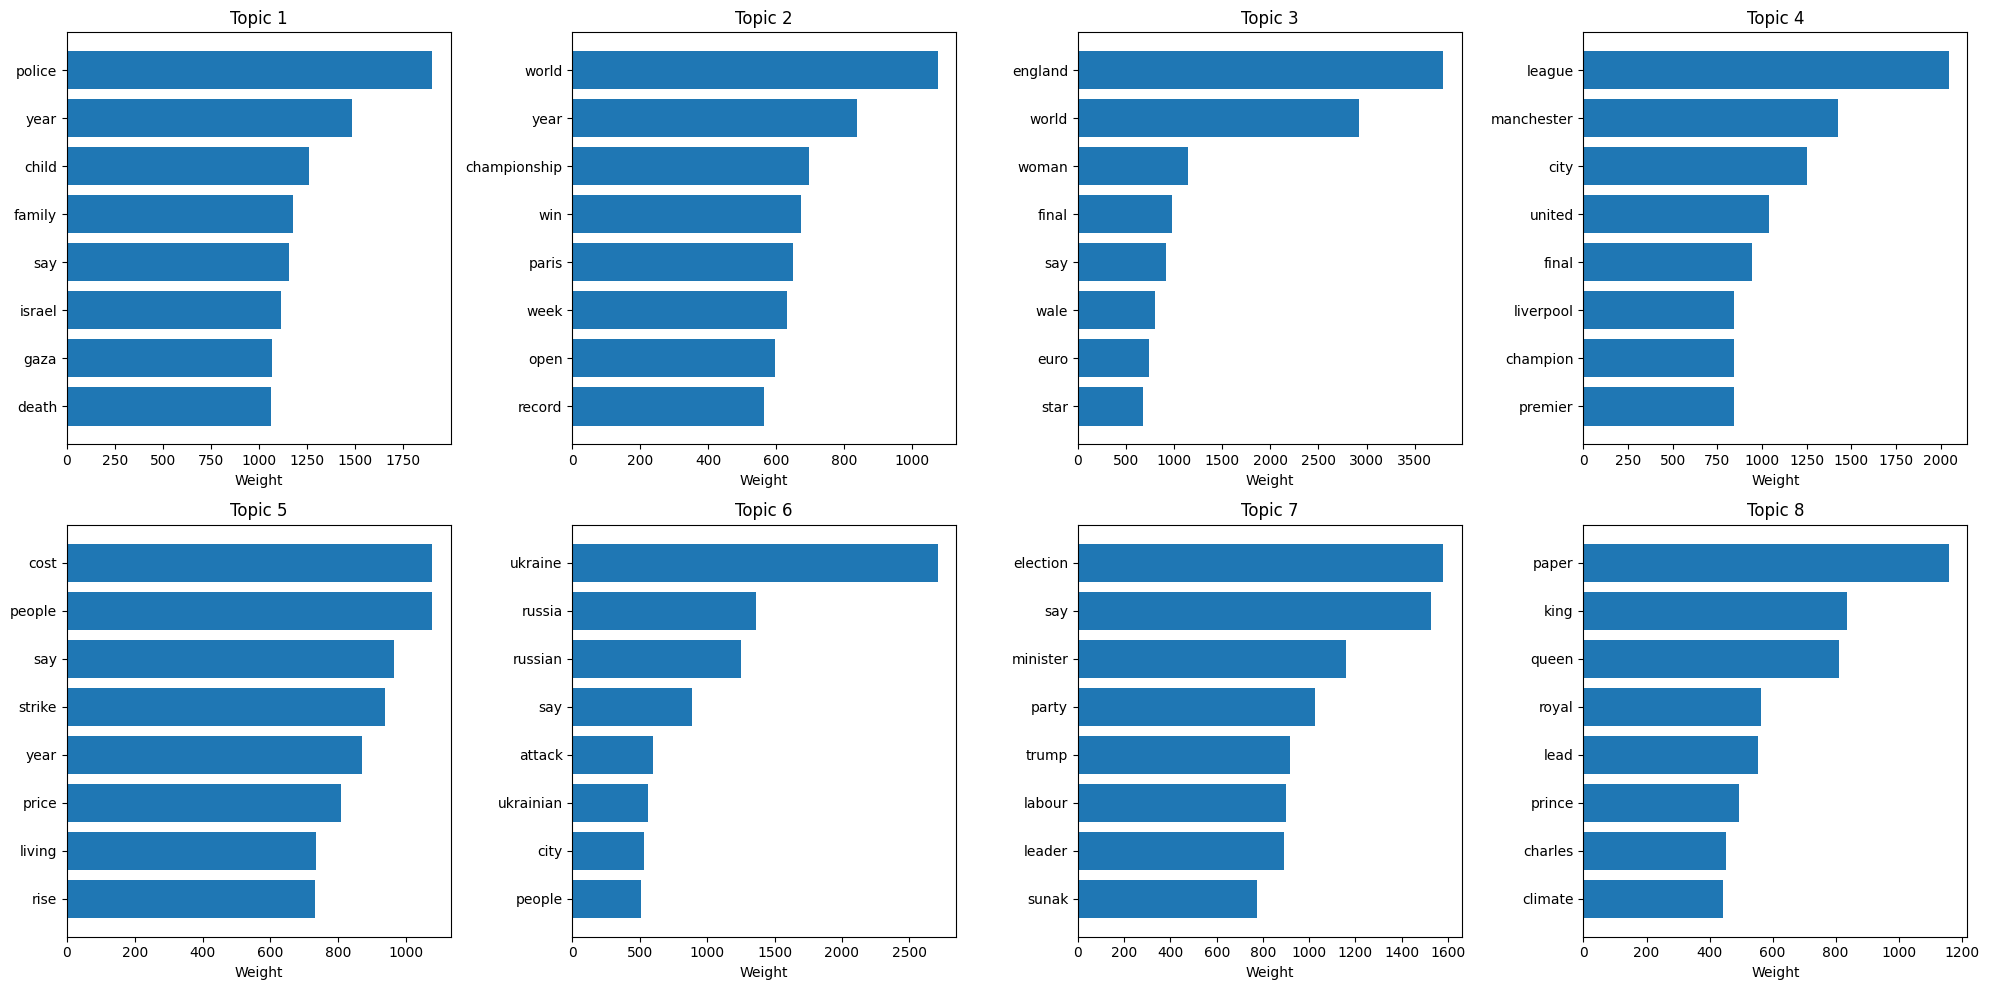

In [ ]:
# Visualize topic-word distribution (optional - requires additional setup)
def plot_top_words(model, feature_names, n_top_words=8):
    """Plot top words for each topic"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx >= len(axes):
            break
            
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_weights = [topic[i] for i in top_words_idx]
        
        axes[topic_idx].barh(range(n_top_words), top_weights[::-1])
        axes[topic_idx].set_yticks(range(n_top_words))
        axes[topic_idx].set_yticklabels(top_words[::-1])
        axes[topic_idx].set_xlabel('Weight')
        axes[topic_idx].set_title(f'Topic {topic_idx + 1}')
    
    plt.tight_layout()
    plt.show()

# Plot the topics
plot_top_words(final_lda, feature_names, n_top_words=8)

# Extract topic words for naming


In [39]:
def extract_topic_words(model, feature_names, n_top_words=10):
    """Extract top words for each topic"""
    topic_words = []
    
    for topic_idx, topic in enumerate(model.components_):
        # Get indices of top words
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topic_words.append(top_words)
    
    return topic_words

In [40]:
def create_topic_names(topic_words):
    """Create meaningful names for topics based on their top words"""
    topic_names = []
    
    for i, words in enumerate(topic_words):
        if len(words) > 0:
            # Join words and convert to lowercase for checking
            words_str = ' '.join(words).lower()
            
            # Check for different topic categories
            if any(word in words_str for word in ['government', 'political', 'minister', 'election', 'party', 'vote', 'parliament']):
                topic_names.append('Politics')
            elif any(word in words_str for word in ['business', 'company', 'market', 'economic', 'economy', 'financial', 'bank', 'money']):
                topic_names.append('Business')
            elif any(word in words_str for word in ['sport', 'team', 'game', 'player', 'match', 'football', 'cricket', 'tennis']):
                topic_names.append('Sports')
            elif any(word in words_str for word in ['technology', 'computer', 'digital', 'tech', 'internet', 'software', 'online']):
                topic_names.append('Technology')
            elif any(word in words_str for word in ['health', 'medical', 'hospital', 'patient', 'doctor', 'disease', 'treatment']):
                topic_names.append('Health')
            elif any(word in words_str for word in ['education', 'school', 'student', 'university', 'teacher', 'learning']):
                topic_names.append('Education')
            elif any(word in words_str for word in ['environment', 'climate', 'environmental', 'energy', 'green', 'carbon']):
                topic_names.append('Environment')
            elif any(word in words_str for word in ['entertainment', 'film', 'movie', 'music', 'celebrity', 'show']):
                topic_names.append('Entertainment')
            else:
                # Use the most representative word as topic name
                topic_names.append(f"Topic_{words[0].title()}")
        else:
            topic_names.append(f"Topic_{i+1}")
    
    return topic_names

In [41]:
# Extract topic words and create names
topic_words = extract_topic_words(final_lda, feature_names, n_top_words=10)
topic_names = create_topic_names(topic_words)

print(f"\nTopic Names:")
print("=" * 30)
for i, (name, words) in enumerate(zip(topic_names, topic_words)):
    print(f"Topic {i+1} - {name}: {', '.join(words[:5])}")

# Update the document analysis with topic names
print(f"\nDominant topics for first 10 documents (with names):")
print("=" * 50)
for i in range(min(10, len(doc_topic_dist))):
    dominant_topic = np.argmax(doc_topic_dist[i])
    confidence = doc_topic_dist[i][dominant_topic]
    topic_name = topic_names[dominant_topic]
    print(f"Document {i+1}: {topic_name} (confidence: {confidence:.3f})")

# Topic distribution summary with names
print(f"\nTopic Distribution Summary (with names):")
print("=" * 40)
topic_counts = np.argmax(doc_topic_dist, axis=1)
for topic_num in range(optimal_n_topics):
    count = np.sum(topic_counts == topic_num)
    percentage = (count / len(topic_counts)) * 100
    topic_name = topic_names[topic_num]
    print(f"{topic_name}: {count} documents ({percentage:.1f}%)")


Topic Names:
Topic 1 - Topic_Police: police, year, child, family, say
Topic 2 - Topic_World: world, year, championship, win, paris
Topic 3 - Topic_England: england, world, woman, final, say
Topic 4 - Topic_League: league, manchester, city, united, final
Topic 5 - Environment: cost, people, say, strike, year
Topic 6 - Topic_Ukraine: ukraine, russia, russian, say, attack
Topic 7 - Politics: election, say, minister, party, trump
Topic 8 - Environment: paper, king, queen, royal, lead

Dominant topics for first 10 documents (with names):
Document 1: Topic_Ukraine (confidence: 0.804)
Document 2: Topic_Ukraine (confidence: 0.681)
Document 3: Environment (confidence: 0.516)
Document 4: Topic_Police (confidence: 0.712)
Document 5: Environment (confidence: 0.757)
Document 6: Politics (confidence: 0.545)
Document 7: Topic_Ukraine (confidence: 0.679)
Document 8: Environment (confidence: 0.408)
Document 9: Environment (confidence: 0.409)
Document 10: Topic_Ukraine (confidence: 0.903)

Topic Distri

* `WordCloud visualization`

* `Bonus`

Creating WordClouds for 8 topics...


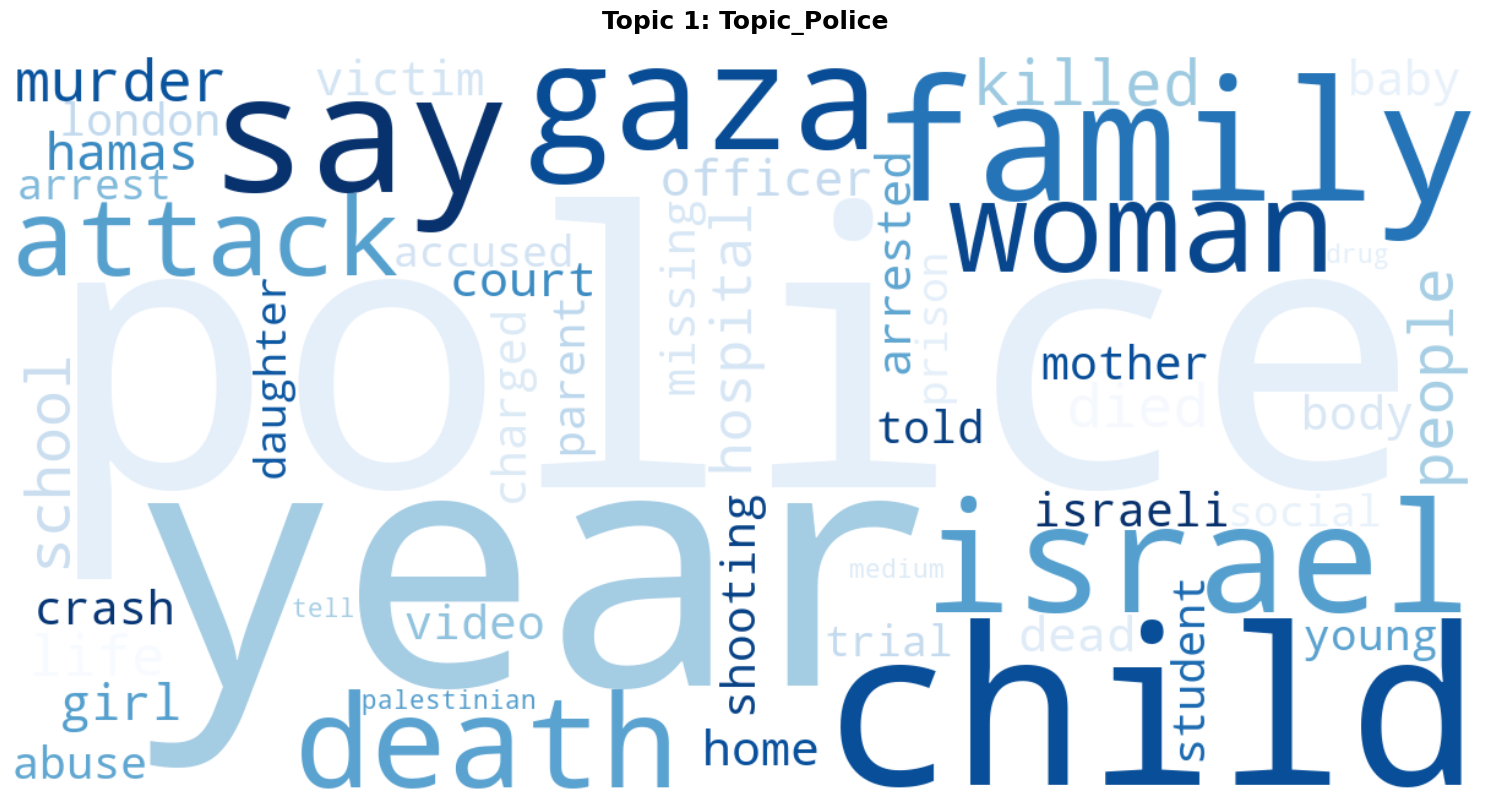

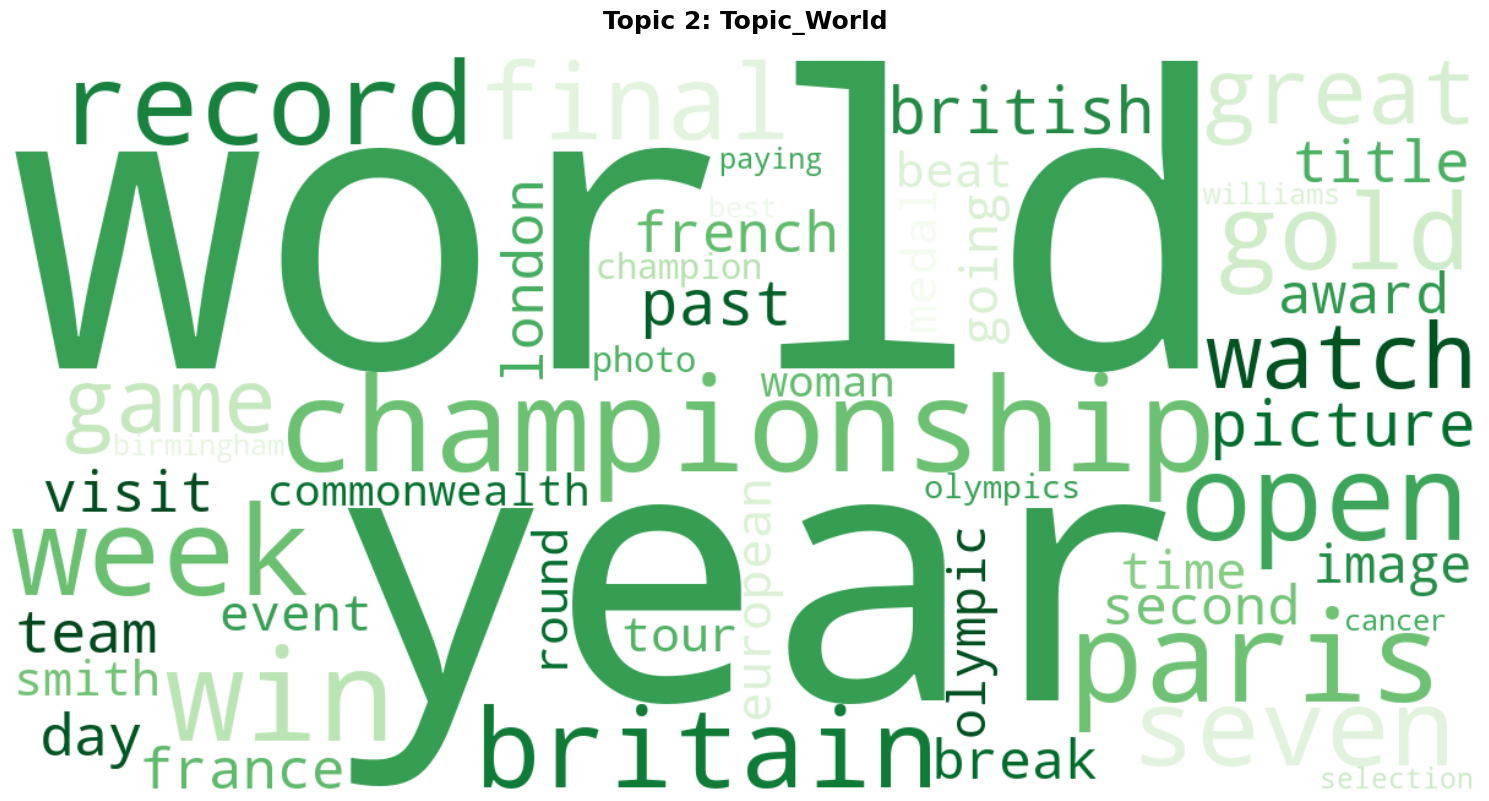

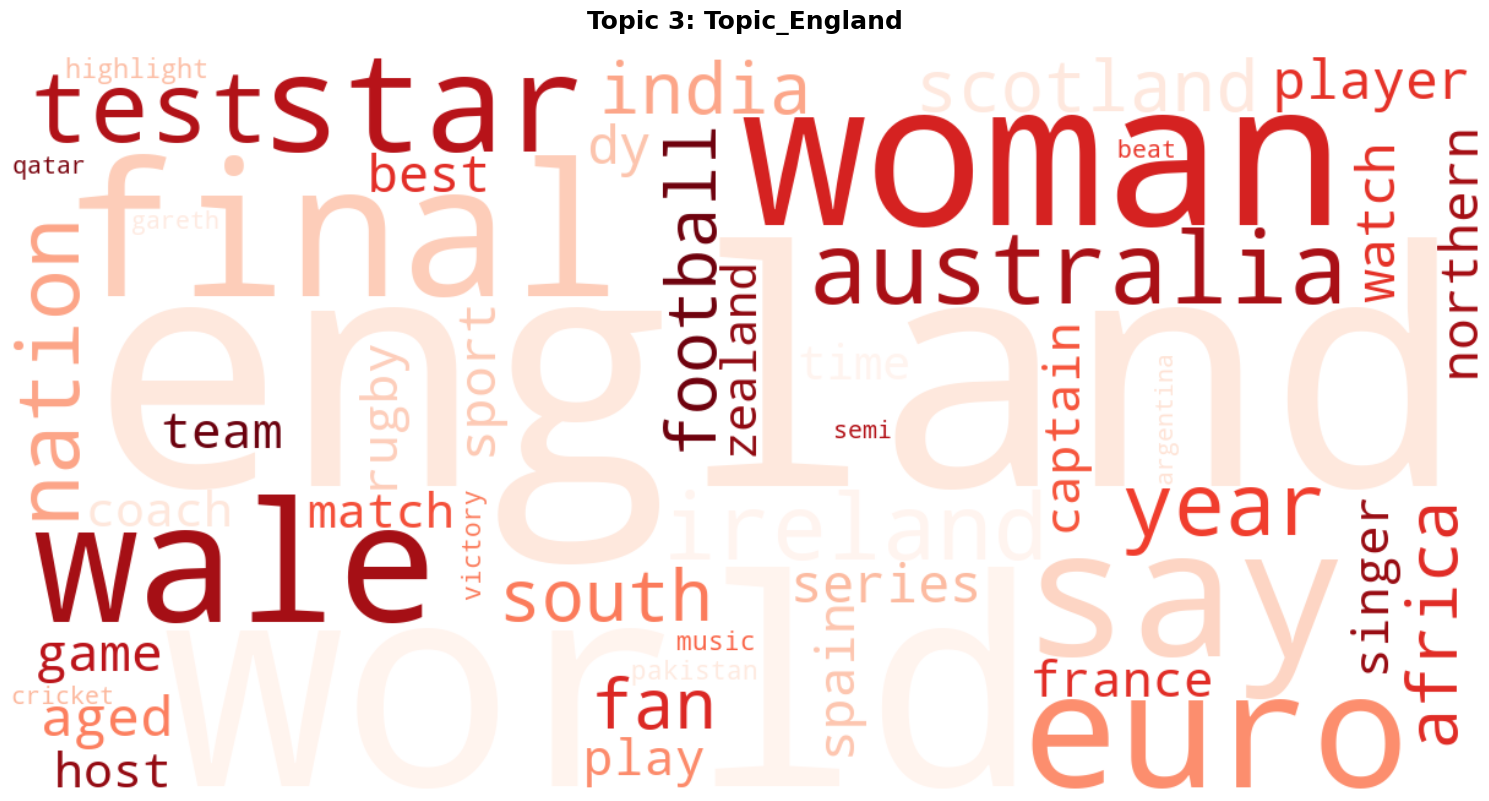

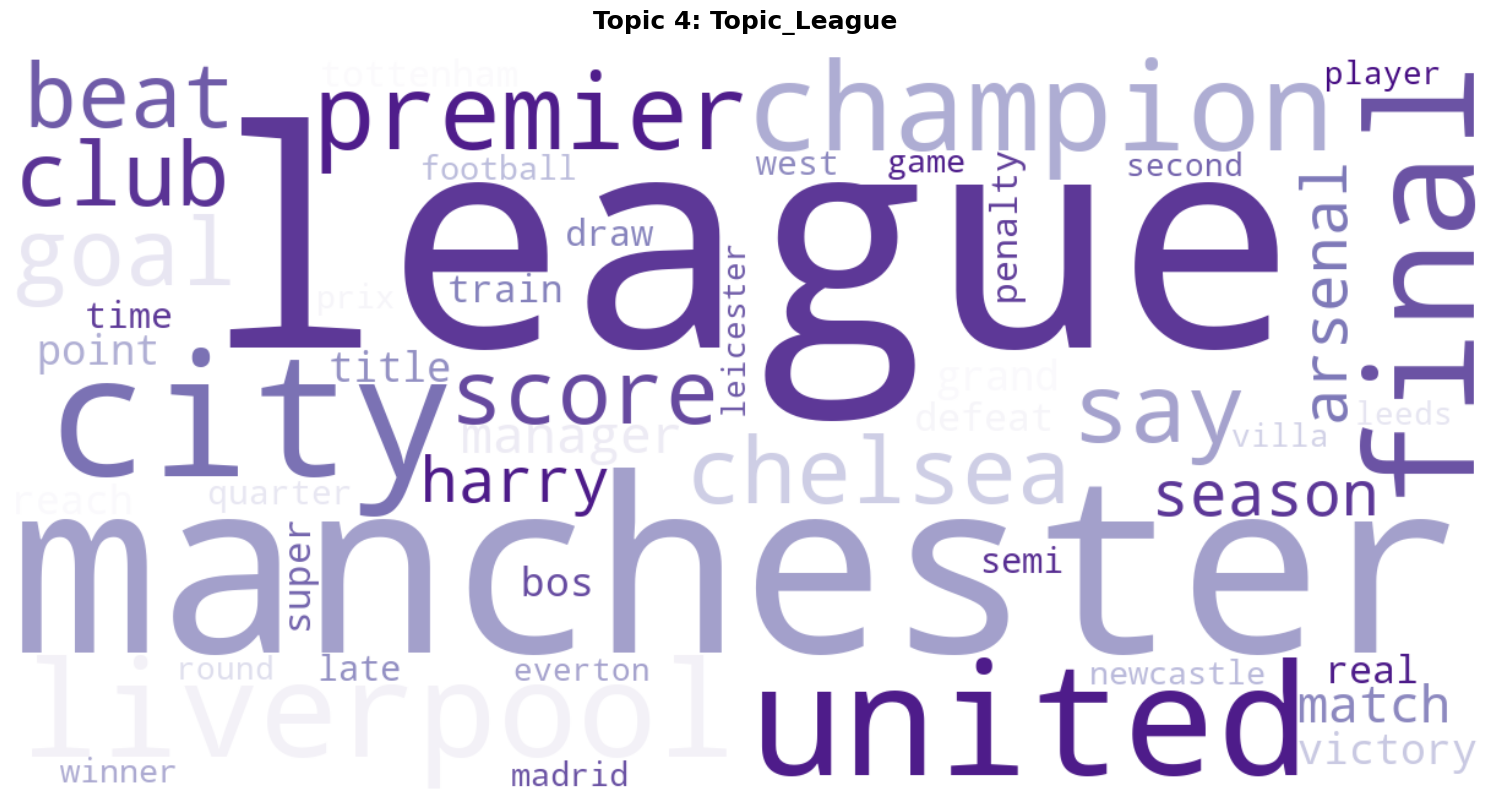

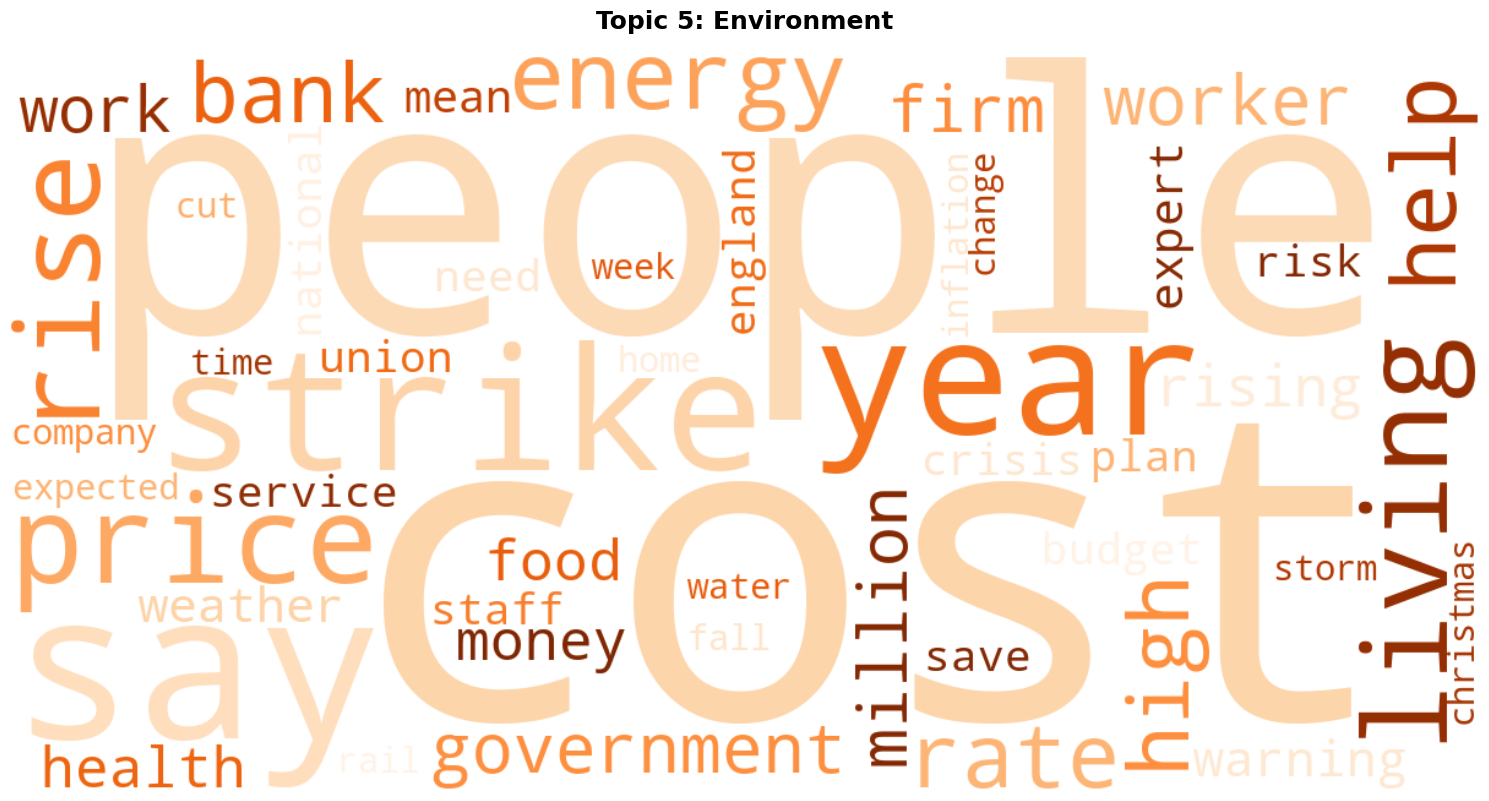

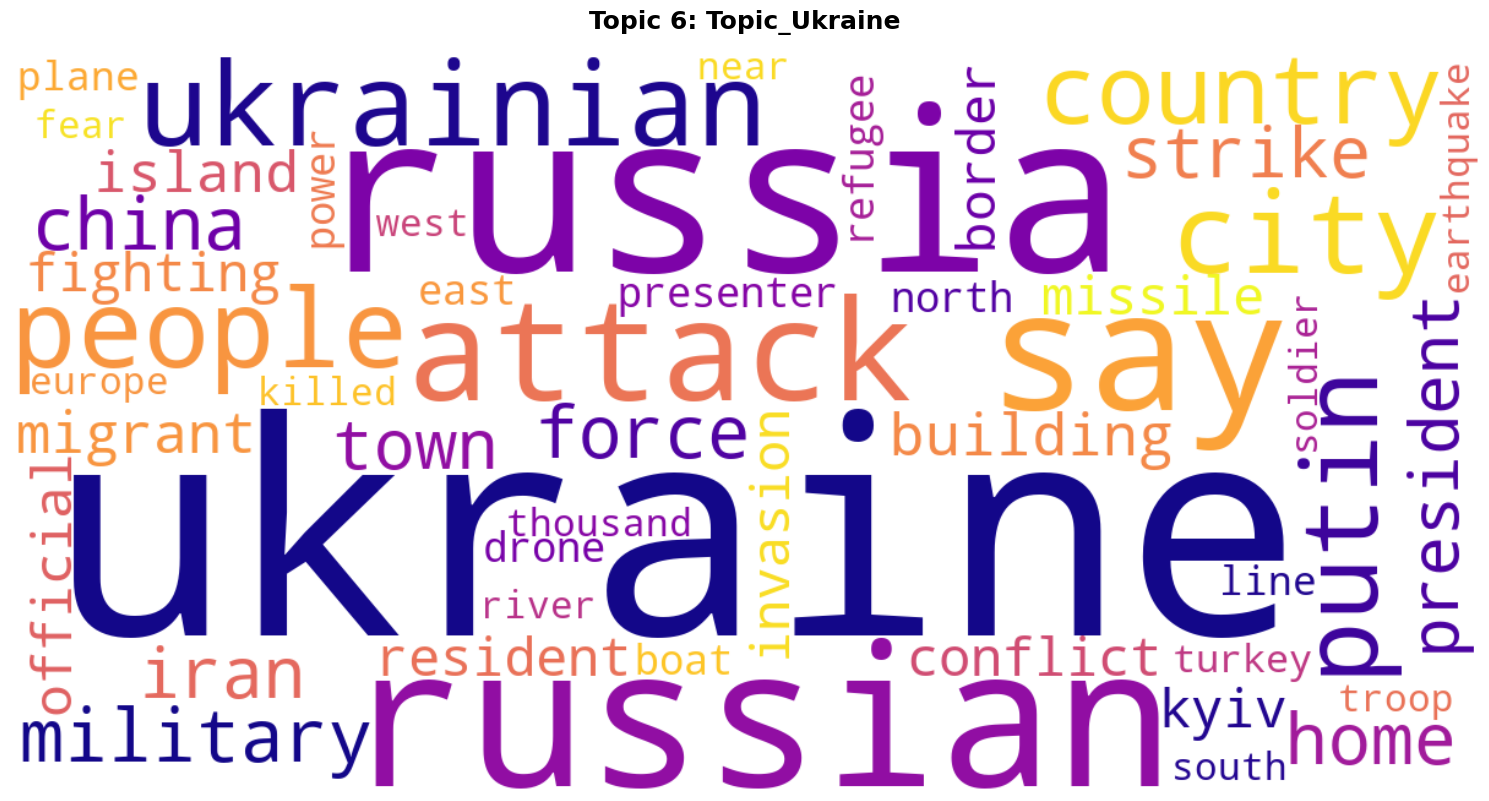

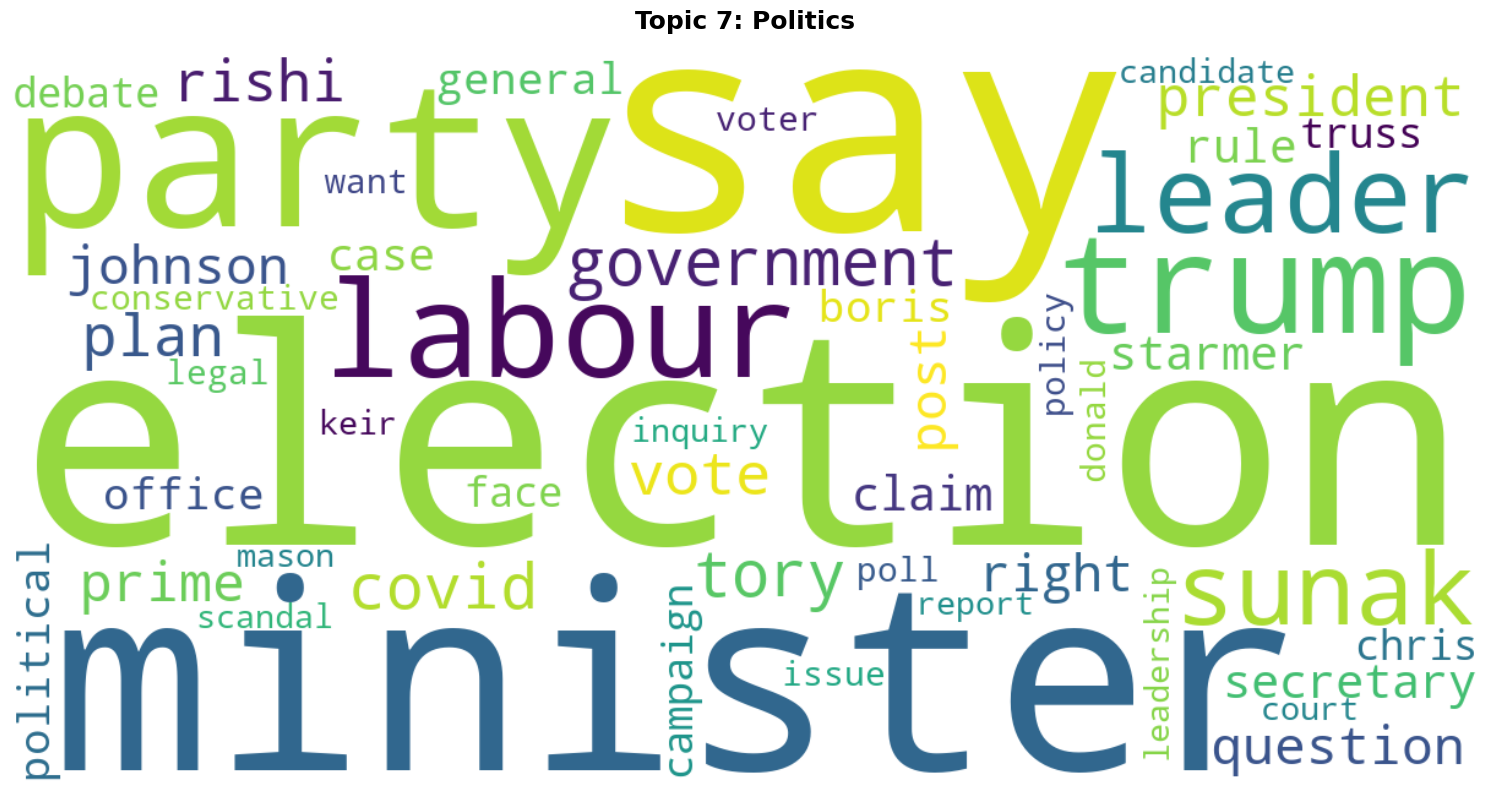

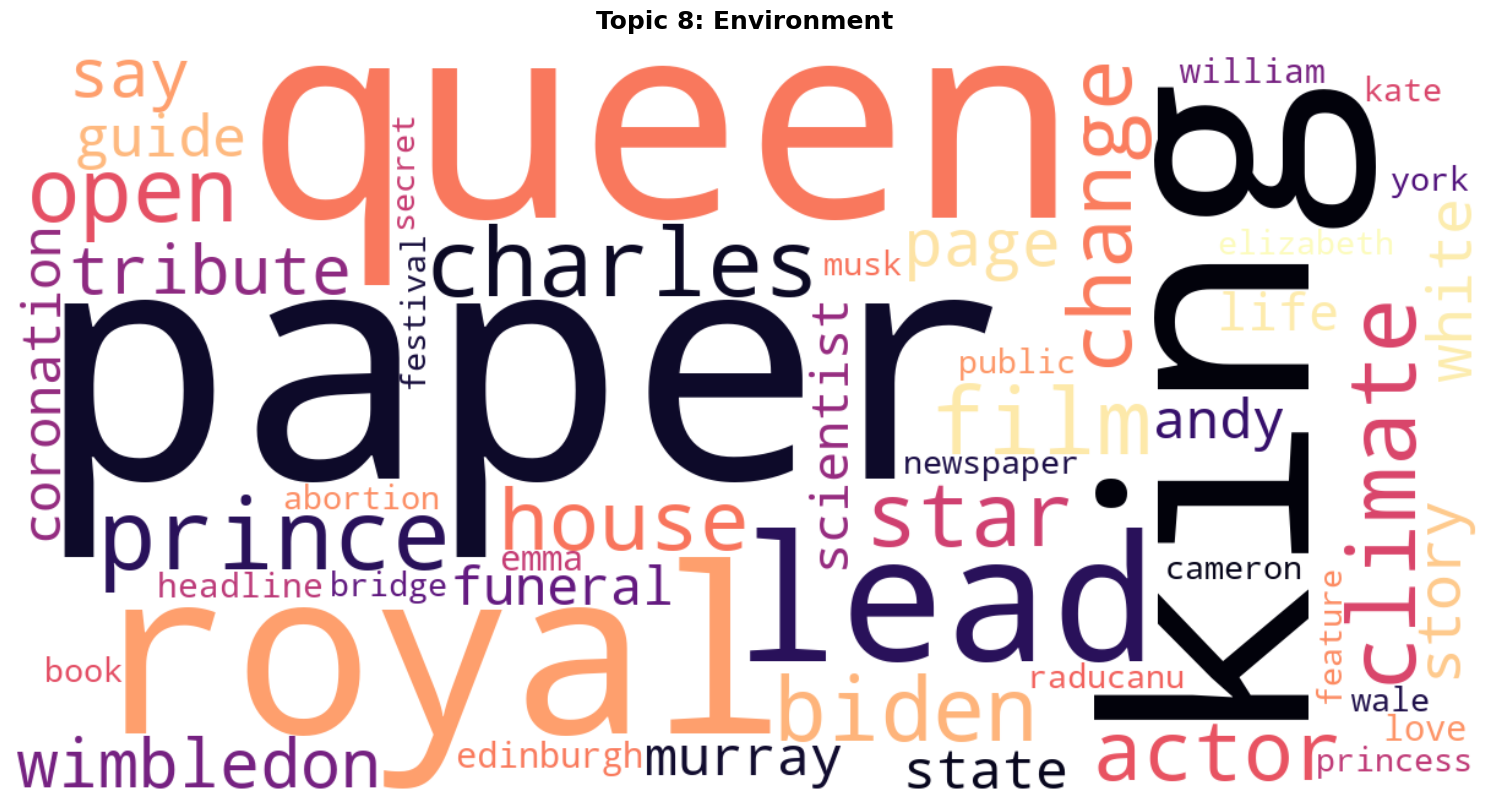

In [42]:
# WordCloud visualization only
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define colors for each topic
colors = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'plasma', 'viridis', 'magma']

def create_wordcloud_from_topic_words(model, feature_names, topic_idx, topic_name, n_words=50):
    """Create wordcloud from LDA topic word weights"""
    topic = model.components_[topic_idx]
    
    # Get top words and their weights
    top_words_idx = topic.argsort()[-n_words:][::-1]
    word_freq = {}
    
    for idx in top_words_idx:
        word = feature_names[idx]
        weight = topic[idx]
        word_freq[word] = weight
    
    # Create WordCloud
    plt.figure(figsize=(15, 8))
    wc = WordCloud(
        max_words=n_words,
        width=1200,
        height=600,
        background_color='white',
        collocations=False,
        colormap=colors[topic_idx % len(colors)],
        relative_scaling=0.5,
        min_font_size=10
    ).generate_from_frequencies(word_freq)
    
    plt.title(f'Topic {topic_idx+1}: {topic_name}', 
              fontsize=18, fontweight='bold', pad=20)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Create WordClouds for all topics
print(f"Creating WordClouds for {optimal_n_topics} topics...")
for i in range(optimal_n_topics):
    topic_name = topic_names[i]
    create_wordcloud_from_topic_words(final_lda, feature_names, i, topic_name, n_words=50)